# ensembling with 6

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# ============================================================================
# STEP 1: UPLOAD FILES
# ============================================================================

# Define the expected models in order of F1 score (highest to lowest)
expected_models = {
    'AutoGluon': 0.6060,
    'CatBoost': 0.60491,
    'XGBoost': 0.60352,
    'TabM': 0.60298,
    'LightGBM': 0.59682,
    'Logistic Regression': 0.59511
}

print("Please upload your 6 CSV files in this order:")
print("="*60)
for i, (model_name, f1_score) in enumerate(expected_models.items(), 1):
    print(f"{i}. {model_name} (F1: {f1_score})")
print("="*60)

# Upload files one by one to maintain order
csv_files = {}
model_f1_scores = {}
model_short_names = {}

for model_name, f1_score in expected_models.items():
    print(f"\n📤 Upload {model_name} predictions (F1: {f1_score}):")
    uploaded = files.upload()

    # Get the uploaded filename
    filename = list(uploaded.keys())[0]
    csv_files[filename] = pd.read_csv(filename)
    model_f1_scores[filename] = f1_score
    model_short_names[filename] = model_name

    print(f"✅ Loaded {filename}: {csv_files[filename].shape}")
    print(csv_files[filename].head(3))

print("\n" + "="*60)
print("All files uploaded successfully!")
print("="*60)


Please upload your 6 CSV files in this order:
1. AutoGluon (F1: 0.606)
2. CatBoost (F1: 0.60491)
3. XGBoost (F1: 0.60352)
4. TabM (F1: 0.60298)
5. LightGBM (F1: 0.59682)
6. Logistic Regression (F1: 0.59511)

📤 Upload AutoGluon predictions (F1: 0.606):


TypeError: 'NoneType' object is not subscriptable

In [ ]:

# ============================================================================
# STEP 2: COMPREHENSIVE DISTRIBUTION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("MODEL DISTRIBUTION ANALYSIS")
print("="*80)

# Assume all CSVs have same columns: claim_number, subrogation
id_col = 'claim_number'
pred_col = 'subrogation'

# Create a combined dataframe with all predictions
first_file = list(csv_files.keys())[0]
combined_df = csv_files[first_file][[id_col]].copy()

# Add predictions from each model
col_name_mapping = {}
for filename in csv_files.keys():
    model_name = model_short_names[filename]
    # Create short column name
    if 'autogluon' in model_name.lower():
        col_name = 'autogluon'
    elif 'catboost' in model_name.lower():
        col_name = 'catboost'
    elif 'tabm' in model_name.lower():
        col_name = 'tabm'
    elif 'xgboost' in model_name.lower():
        col_name = 'xgboost'
    elif 'lightgbm' in model_name.lower():
        col_name = 'lightgbm'
    elif 'logistic' in model_name.lower() or 'logreg' in model_name.lower():
        col_name = 'logreg'
    else:
        col_name = model_name.lower().replace(' ', '_')

    combined_df[col_name] = csv_files[filename][pred_col].values
    col_name_mapping[col_name] = (filename, model_f1_scores[filename])
    print(f"Added {col_name:15s} (F1: {model_f1_scores[filename]:.5f})")

model_cols = [col for col in combined_df.columns if col != id_col]
print(f"\nModel columns: {model_cols}")

# ============================================================================
# 1. CLASS DISTRIBUTION FOR EACH MODEL
# ============================================================================

print("\n" + "="*80)
print("1. CLASS DISTRIBUTION (Class 1 predictions)")
print("="*80)

class1_dist = {}
for col in model_cols:
    count_1 = (combined_df[col] == 1).sum()
    count_0 = (combined_df[col] == 0).sum()
    pct_1 = count_1 / len(combined_df) * 100
    class1_dist[col] = pct_1
    print(f"{col:15s}: {count_1:5,} (1s) = {pct_1:5.2f}% | {count_0:5,} (0s) = {100-pct_1:5.2f}%")

# Sort by Class 1 percentage
sorted_models = sorted(class1_dist.items(), key=lambda x: x[1], reverse=True)
print("\nRanked by Class 1 prediction rate (highest to lowest):")
for i, (model, pct) in enumerate(sorted_models, 1):
    f1_score = col_name_mapping[model][1]
    print(f"  {i}. {model:15s}: {pct:.2f}% Class 1 | F1: {f1_score:.5f}")

# ============================================================================
# 2. PAIRWISE AGREEMENT MATRIX
# ============================================================================

print("\n" + "="*80)
print("2. PAIRWISE AGREEMENT MATRIX (%)")
print("="*80)

agreement_matrix = pd.DataFrame(index=model_cols, columns=model_cols, dtype=float)
for model1 in model_cols:
    for model2 in model_cols:
        if model1 == model2:
            agreement_matrix.loc[model1, model2] = 100.0
        else:
            agreement = (combined_df[model1] == combined_df[model2]).sum()
            agreement_pct = agreement / len(combined_df) * 100
            agreement_matrix.loc[model1, model2] = agreement_pct

print(agreement_matrix.round(2))

# Find most similar and most different pairs
print("\n📊 Most Similar Model Pairs:")
pairs = []
for i, model1 in enumerate(model_cols):
    for model2 in model_cols[i+1:]:
        pairs.append((model1, model2, agreement_matrix.loc[model1, model2]))

pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)
for i, (m1, m2, agreement) in enumerate(pairs_sorted[:5], 1):
    print(f"  {i}. {m1:12s} ↔ {m2:12s}: {agreement:.2f}% agreement")

print("\n📊 Most Diverse Model Pairs:")
for i, (m1, m2, agreement) in enumerate(reversed(pairs_sorted[-5:]), 1):
    print(f"  {i}. {m1:12s} ↔ {m2:12s}: {agreement:.2f}% agreement")

# ============================================================================
# 3. MODEL DIVERSITY SCORE
# ============================================================================

print("\n" + "="*80)
print("3. MODEL DIVERSITY ANALYSIS")
print("="*80)

# Calculate average disagreement for each model (diversity contribution)
diversity_scores = {}
for model in model_cols:
    disagreements = []
    for other_model in model_cols:
        if model != other_model:
            disagreement = (combined_df[model] != combined_df[other_model]).sum()
            disagreements.append(disagreement)
    avg_disagreement = np.mean(disagreements)
    diversity_scores[model] = avg_disagreement

print("Average disagreement with other models (higher = more diverse):")
sorted_diversity = sorted(diversity_scores.items(), key=lambda x: x[1], reverse=True)
for i, (model, score) in enumerate(sorted_diversity, 1):
    pct = score / len(combined_df) * 100
    f1_score = col_name_mapping[model][1]
    print(f"  {i}. {model:15s}: {score:6.0f} disagreements ({pct:.2f}%) | F1: {f1_score:.5f}")

# ============================================================================
# 4. CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("4. CORRELATION MATRIX")
print("="*80)

corr_matrix = combined_df[model_cols].corr()
print(corr_matrix.round(3))

# ============================================================================
# 5. VOTING PATTERN ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("5. VOTING PATTERNS")
print("="*80)

# Count unanimous, strong majority, etc.
combined_df['total_votes_for_1'] = combined_df[model_cols].sum(axis=1)
combined_df['total_votes_for_0'] = 6 - combined_df['total_votes_for_1']

vote_dist = combined_df['total_votes_for_1'].value_counts().sort_index(ascending=False)
print("Distribution of votes for Class 1:")
for votes, count in vote_dist.items():
    pct = count / len(combined_df) * 100
    print(f"  {votes}/6 models predict 1: {count:5,} cases ({pct:5.2f}%)")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Class 1 prediction rates
ax1 = fig.add_subplot(gs[0, 0])
sorted_models_names = [x[0] for x in sorted_models]
sorted_models_pcts = [x[1] for x in sorted_models]
colors_bar = plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_models_names)))
ax1.barh(sorted_models_names, sorted_models_pcts, color=colors_bar)
ax1.set_xlabel('% Class 1 Predictions')
ax1.set_title('Class 1 Prediction Rate by Model', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, (name, pct) in enumerate(zip(sorted_models_names, sorted_models_pcts)):
    ax1.text(pct + 0.5, i, f'{pct:.1f}%', va='center')

# Plot 2: Agreement heatmap
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(agreement_matrix.values, annot=True, fmt='.1f', cmap='RdYlGn',
            xticklabels=model_cols, yticklabels=model_cols, ax=ax2,
            vmin=80, vmax=100, cbar_kws={'label': 'Agreement %'})
ax2.set_title('Pairwise Agreement Heatmap', fontweight='bold')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Plot 3: Correlation heatmap
ax3 = fig.add_subplot(gs[0, 2])
sns.heatmap(corr_matrix.values, annot=True, fmt='.3f', cmap='coolwarm',
            xticklabels=model_cols, yticklabels=model_cols, ax=ax3,
            vmin=0.7, vmax=1.0, center=0.85, cbar_kws={'label': 'Correlation'})
ax3.set_title('Correlation Matrix', fontweight='bold')
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

# Plot 4: Diversity scores
ax4 = fig.add_subplot(gs[1, 0])
sorted_div_names = [x[0] for x in sorted_diversity]
sorted_div_scores = [x[1]/len(combined_df)*100 for x in sorted_diversity]
colors_div = plt.cm.plasma(np.linspace(0.3, 0.9, len(sorted_div_names)))
ax4.barh(sorted_div_names, sorted_div_scores, color=colors_div)
ax4.set_xlabel('Average Disagreement %')
ax4.set_title('Model Diversity Scores', fontweight='bold')
ax4.grid(axis='x', alpha=0.3)
for i, (name, score) in enumerate(zip(sorted_div_names, sorted_div_scores)):
    ax4.text(score + 0.2, i, f'{score:.1f}%', va='center')

# Plot 5: Vote distribution
ax5 = fig.add_subplot(gs[1, 1])
vote_counts = [vote_dist.get(i, 0) for i in range(7)]
colors_vote = ['#d73027', '#fc8d59', '#fee090', '#ffffbf', '#e0f3f8', '#91bfdb', '#4575b4']
ax5.bar(range(7), vote_counts, color=colors_vote, edgecolor='black', alpha=0.8)
ax5.set_xlabel('Number of models predicting Class 1')
ax5.set_ylabel('Number of cases')
ax5.set_title('Voting Pattern Distribution', fontweight='bold')
ax5.set_xticks(range(7))
ax5.set_xticklabels([f'{i}/6' for i in range(7)])
ax5.grid(axis='y', alpha=0.3)
for i, count in enumerate(vote_counts):
    if count > 0:
        pct = count / len(combined_df) * 100
        ax5.text(i, count + 50, f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)

# Plot 6: F1 scores
ax6 = fig.add_subplot(gs[1, 2])
f1_data = [(col, col_name_mapping[col][1]) for col in model_cols]
f1_data_sorted = sorted(f1_data, key=lambda x: x[1], reverse=True)
f1_names = [x[0] for x in f1_data_sorted]
f1_scores = [x[1] for x in f1_data_sorted]
colors_f1 = plt.cm.RdYlGn(np.linspace(0.4, 0.9, len(f1_names)))
ax6.barh(f1_names, f1_scores, color=colors_f1, edgecolor='black')
ax6.set_xlabel('F1 Score')
ax6.set_title('Model Performance (F1 Scores)', fontweight='bold')
ax6.set_xlim([0.59, 0.61])
ax6.grid(axis='x', alpha=0.3)
for i, (name, score) in enumerate(zip(f1_names, f1_scores)):
    ax6.text(score + 0.0005, i, f'{score:.5f}', va='center', fontsize=9)

# Plot 7: Model prediction comparison (stacked bar)
ax7 = fig.add_subplot(gs[2, :])
class0_counts = [(combined_df[col] == 0).sum() for col in model_cols]
class1_counts = [(combined_df[col] == 1).sum() for col in model_cols]
x_pos = np.arange(len(model_cols))
ax7.bar(x_pos, class0_counts, label='Class 0', color='lightcoral', edgecolor='black')
ax7.bar(x_pos, class1_counts, bottom=class0_counts, label='Class 1', color='mediumseagreen', edgecolor='black')
ax7.set_xticks(x_pos)
ax7.set_xticklabels(model_cols, rotation=45, ha='right')
ax7.set_ylabel('Number of Predictions')
ax7.set_title('Class Distribution Comparison Across Models', fontweight='bold')
ax7.legend()
ax7.grid(axis='y', alpha=0.3)

# Add percentages
for i, col in enumerate(model_cols):
    class1_pct = class1_counts[i] / len(combined_df) * 100
    ax7.text(i, class0_counts[i] + class1_counts[i]/2, f'{class1_pct:.1f}%',
            ha='center', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# ============================================================================
# RECOMMENDATIONS
# ============================================================================

print("\n" + "="*80)
print("ENSEMBLE RECOMMENDATIONS")
print("="*80)

print("\n💡 Based on the analysis:")
print("\n1. MOST DIVERSE MODELS (pick these for maximum diversity):")
most_diverse = sorted_diversity[:3]
for i, (model, score) in enumerate(most_diverse, 1):
    pct = score / len(combined_df) * 100
    f1_score = col_name_mapping[model][1]
    print(f"   {i}. {model} (diversity: {pct:.2f}%, F1: {f1_score:.5f})")

print("\n2. TOP PERFORMING MODELS:")
top_performers = sorted(f1_data, key=lambda x: x[1], reverse=True)[:3]
for i, (model, f1) in enumerate(top_performers, 1):
    print(f"   {i}. {model} (F1: {f1:.5f})")

print("\n3. MODELS TO POTENTIALLY EXCLUDE (too similar to others):")
# Find models with highest average agreement
avg_agreement = {}
for model in model_cols:
    agreements = [agreement_matrix.loc[model, other] for other in model_cols if other != model]
    avg_agreement[model] = np.mean(agreements)

most_similar = sorted(avg_agreement.items(), key=lambda x: x[1], reverse=True)[:2]
for i, (model, avg_agree) in enumerate(most_similar, 1):
    f1_score = col_name_mapping[model][1]
    print(f"   {i}. {model} (avg agreement: {avg_agree:.2f}%, F1: {f1_score:.5f})")

print("\n4. SUGGESTED ENSEMBLE COMBINATIONS:")
print("\n   Option A - Top 3 Performers: AutoGluon, CatBoost, XGBoost")
print("   Option B - Maximum Diversity: [check diversity scores above]")
print("   Option C - All Boosting Models: AutoGluon, CatBoost, XGBoost, LightGBM (skip LogReg, TabM)")
print("   Option D - All 6 models with median voting")

print("\n" + "="*80)

# Save combined results for later use
print("\n💾 Saving combined dataframe for ensemble experiments...")
combined_df.to_csv('all_6_models_predictions.csv', index=False)
print("✅ Saved as: all_6_models_predictions.csv")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# LOAD THE COMBINED DATA (from previous script)
# ============================================================================

combined_df = pd.read_csv('all_6_models_predictions.csv')
id_col = 'claim_number'

print("="*80)
print("COMPREHENSIVE ENSEMBLE COMPARISON: 6 vs 5 vs 3 MODELS")
print("="*80)

# ============================================================================
# DEFINE THREE ENSEMBLE STRATEGIES
# ============================================================================

# Strategy 1: All 6 models with median voting (>=4 votes for Class 1)
strategy1_models = ['autogluon', 'catboost', 'xgboost', 'tabm', 'lightgbm', 'logreg']
strategy1_weights = {
    'autogluon': 0.60600,
    'catboost': 0.60491,
    'xgboost': 0.60352,
    'tabm': 0.60298,
    'lightgbm': 0.59682,
    'logreg': 0.59511
}

# Strategy 2: Top 5 models (drop LogReg) with median voting (>=3 votes for Class 1)
strategy2_models = ['autogluon', 'catboost', 'xgboost', 'tabm', 'lightgbm']
strategy2_weights = {
    'autogluon': 0.60600,
    'catboost': 0.60491,
    'xgboost': 0.60352,
    'tabm': 0.60298,
    'lightgbm': 0.59682
}

# Strategy 3: Top 3 models (simple majority - >=2 votes for Class 1)
strategy3_models = ['autogluon', 'catboost', 'xgboost']
strategy3_weights = {
    'autogluon': 0.60600,
    'catboost': 0.60491,
    'xgboost': 0.60352
}

# ============================================================================
# GENERATE PREDICTIONS FOR ALL THREE STRATEGIES
# ============================================================================

def generate_ensemble_predictions(df, models, weights, threshold_type='median'):
    """
    Generate ensemble predictions using both simple voting and weighted voting
    """
    results = {}

    # Simple majority/median voting
    votes_for_1 = df[models].sum(axis=1)

    if threshold_type == 'median':
        # For median: need more than half
        threshold = len(models) / 2
        results['simple_majority'] = (votes_for_1 > threshold).astype(int)
    else:
        # For even number, use >= threshold
        threshold = len(models) / 2
        results['simple_majority'] = (votes_for_1 >= threshold).astype(int)

    # Weighted voting
    weighted_sum = sum(df[model] * weight for model, weight in weights.items())
    total_weight = sum(weights.values())
    weighted_threshold = total_weight / 2
    results['weighted'] = (weighted_sum >= weighted_threshold).astype(int)

    # Store vote counts
    results['votes_for_1'] = votes_for_1
    results['votes_for_0'] = len(models) - votes_for_1

    return results

print("\nGenerating predictions for all strategies...")

# Strategy 1: 6 models
s1_results = generate_ensemble_predictions(combined_df, strategy1_models, strategy1_weights)
combined_df['s1_simple'] = s1_results['simple_majority']
combined_df['s1_weighted'] = s1_results['weighted']
combined_df['s1_votes_1'] = s1_results['votes_for_1']

# Strategy 2: 5 models
s2_results = generate_ensemble_predictions(combined_df, strategy2_models, strategy2_weights)
combined_df['s2_simple'] = s2_results['simple_majority']
combined_df['s2_weighted'] = s2_results['weighted']
combined_df['s2_votes_1'] = s2_results['votes_for_1']

# Strategy 3: 3 models
s3_results = generate_ensemble_predictions(combined_df, strategy3_models, strategy3_weights)
combined_df['s3_simple'] = s3_results['simple_majority']
combined_df['s3_weighted'] = s3_results['weighted']
combined_df['s3_votes_1'] = s3_results['votes_for_1']

print("✅ All predictions generated!")

# ============================================================================
# COMPARE PREDICTION DISTRIBUTIONS
# ============================================================================

print("\n" + "="*80)
print("PREDICTION DISTRIBUTION COMPARISON")
print("="*80)

strategies = [
    ('6 models (simple)', 's1_simple', 's1_votes_1', 6),
    ('6 models (weighted)', 's1_weighted', 's1_votes_1', 6),
    ('5 models (simple)', 's2_simple', 's2_votes_1', 5),
    ('5 models (weighted)', 's2_weighted', 's2_votes_1', 5),
    ('3 models (simple)', 's3_simple', 's3_votes_1', 3),
    ('3 models (weighted)', 's3_weighted', 's3_votes_1', 3)
]

summary_stats = []

for name, pred_col, votes_col, n_models in strategies:
    class_1_count = (combined_df[pred_col] == 1).sum()
    class_0_count = (combined_df[pred_col] == 0).sum()
    pct_1 = class_1_count / len(combined_df) * 100

    summary_stats.append({
        'Strategy': name,
        'Class 1': class_1_count,
        'Class 0': class_0_count,
        '% Class 1': pct_1
    })

    print(f"\n{name:25s}: {class_1_count:5,} (1s) = {pct_1:5.2f}% | {class_0_count:5,} (0s) = {100-pct_1:5.2f}%")

summary_df = pd.DataFrame(summary_stats)
print("\n" + summary_df.to_string(index=False))

# ============================================================================
# ANALYZE DISAGREEMENT CASES
# ============================================================================

print("\n" + "="*80)
print("DISAGREEMENT ANALYSIS - WHERE DO STRATEGIES DIFFER?")
print("="*80)

# Compare strategies pairwise
comparisons = [
    ('6 simple vs 5 simple', 's1_simple', 's2_simple'),
    ('6 simple vs 3 simple', 's1_simple', 's3_simple'),
    ('5 simple vs 3 simple', 's2_simple', 's3_simple'),
    ('6 weighted vs 5 weighted', 's1_weighted', 's2_weighted'),
    ('6 weighted vs 3 weighted', 's1_weighted', 's3_weighted'),
    ('5 weighted vs 3 weighted', 's2_weighted', 's3_weighted'),
]

print("\nAgreement between strategies:")
for name, col1, col2 in comparisons:
    agreement = (combined_df[col1] == combined_df[col2]).sum()
    disagreement = len(combined_df) - agreement
    pct_agree = agreement / len(combined_df) * 100
    print(f"{name:30s}: {agreement:5,} agree ({pct_agree:5.2f}%), {disagreement:4,} disagree ({100-pct_agree:5.2f}%)")

# ============================================================================
# DETAILED DISAGREEMENT CASE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("DETAILED DISAGREEMENT CASES")
print("="*80)

# Find cases where strategies disagree
print("\n1. Cases where 6-model differs from 5-model (SIMPLE voting):")
diff_6vs5 = combined_df[combined_df['s1_simple'] != combined_df['s2_simple']].copy()
print(f"   Total: {len(diff_6vs5)} cases ({len(diff_6vs5)/len(combined_df)*100:.2f}%)")

if len(diff_6vs5) > 0:
    print(f"\n   Breakdown:")
    print(f"   - 6-model predicts 1, 5-model predicts 0: {((diff_6vs5['s1_simple']==1) & (diff_6vs5['s2_simple']==0)).sum()}")
    print(f"   - 6-model predicts 0, 5-model predicts 1: {((diff_6vs5['s1_simple']==0) & (diff_6vs5['s2_simple']==1)).sum()}")

    # Show what LogReg predicted in these cases
    print(f"\n   LogReg's role in these disagreements:")
    logreg_1_when_differ = diff_6vs5['logreg'].sum()
    print(f"   - LogReg predicted 1: {logreg_1_when_differ} times ({logreg_1_when_differ/len(diff_6vs5)*100:.1f}%)")
    print(f"   - LogReg predicted 0: {len(diff_6vs5) - logreg_1_when_differ} times ({(len(diff_6vs5) - logreg_1_when_differ)/len(diff_6vs5)*100:.1f}%)")

    # Show vote patterns
    print(f"\n   Vote patterns in 6-model ensemble for these cases:")
    vote_pattern_6 = diff_6vs5['s1_votes_1'].value_counts().sort_index()
    for votes, count in vote_pattern_6.items():
        print(f"   - {int(votes)}/6 voted for 1: {count} cases")

    print(f"\n   Sample disagreement cases:")
    print(diff_6vs5[['claim_number', 'autogluon', 'catboost', 'xgboost', 'tabm', 'lightgbm', 'logreg',
                     's1_votes_1', 's1_simple', 's2_simple']].head(20))

print("\n2. Cases where 5-model differs from 3-model (SIMPLE voting):")
diff_5vs3 = combined_df[combined_df['s2_simple'] != combined_df['s3_simple']].copy()
print(f"   Total: {len(diff_5vs3)} cases ({len(diff_5vs3)/len(combined_df)*100:.2f}%)")

if len(diff_5vs3) > 0:
    print(f"\n   Breakdown:")
    print(f"   - 5-model predicts 1, 3-model predicts 0: {((diff_5vs3['s2_simple']==1) & (diff_5vs3['s3_simple']==0)).sum()}")
    print(f"   - 5-model predicts 0, 3-model predicts 1: {((diff_5vs3['s2_simple']==0) & (diff_5vs3['s3_simple']==1)).sum()}")

    # Show what TabM and LightGBM predicted
    print(f"\n   TabM & LightGBM's role in these disagreements:")
    print(f"   - TabM predicted 1: {diff_5vs3['tabm'].sum()} times")
    print(f"   - LightGBM predicted 1: {diff_5vs3['lightgbm'].sum()} times")

    # Show vote patterns
    print(f"\n   Vote patterns for top 3 models in these cases:")
    vote_pattern_3 = diff_5vs3['s3_votes_1'].value_counts().sort_index()
    for votes, count in vote_pattern_3.items():
        print(f"   - {int(votes)}/3 voted for 1: {count} cases")

    print(f"\n   Sample disagreement cases:")
    print(diff_5vs3[['claim_number', 'autogluon', 'catboost', 'xgboost', 'tabm', 'lightgbm',
                     's3_votes_1', 's2_simple', 's3_simple']].head(20))

print("\n3. Cases where 6-model differs from 3-model (SIMPLE voting):")
diff_6vs3 = combined_df[combined_df['s1_simple'] != combined_df['s3_simple']].copy()
print(f"   Total: {len(diff_6vs3)} cases ({len(diff_6vs3)/len(combined_df)*100:.2f}%)")

if len(diff_6vs3) > 0:
    print(f"\n   Breakdown:")
    print(f"   - 6-model predicts 1, 3-model predicts 0: {((diff_6vs3['s1_simple']==1) & (diff_6vs3['s3_simple']==0)).sum()}")
    print(f"   - 6-model predicts 0, 3-model predicts 1: {((diff_6vs3['s1_simple']==0) & (diff_6vs3['s3_simple']==1)).sum()}")

# ============================================================================
# FOCUS ON CRITICAL DISAGREEMENT ZONES
# ============================================================================

print("\n" + "="*80)
print("CRITICAL DISAGREEMENT ZONES - WHERE MODELS ARE UNCERTAIN")
print("="*80)

# For 6 models: 2-4, 3-3, 4-2 votes are uncertain
uncertain_6 = combined_df[combined_df['s1_votes_1'].isin([2, 3, 4])].copy()
print(f"\n6-model uncertain cases (2-4, 3-3, 4-2 votes): {len(uncertain_6)} cases ({len(uncertain_6)/len(combined_df)*100:.2f}%)")

if len(uncertain_6) > 0:
    print("\nHow each strategy handles these uncertain cases:")
    for name, pred_col, _, _ in strategies:
        pred_1_count = (uncertain_6[pred_col] == 1).sum()
        pred_0_count = len(uncertain_6) - pred_1_count
        print(f"  {name:25s}: {pred_1_count:4,} predict 1 ({pred_1_count/len(uncertain_6)*100:5.1f}%), {pred_0_count:4,} predict 0 ({pred_0_count/len(uncertain_6)*100:5.1f}%)")

# For 5 models: 2-3, 3-2 votes are uncertain
uncertain_5 = combined_df[combined_df['s2_votes_1'].isin([2, 3])].copy()
print(f"\n5-model uncertain cases (2-3, 3-2 votes): {len(uncertain_5)} cases ({len(uncertain_5)/len(combined_df)*100:.2f}%)")

if len(uncertain_5) > 0:
    print("\nHow each strategy handles these uncertain cases:")
    for name, pred_col, _, _ in strategies:
        if name.startswith('5') or name.startswith('3'):
            pred_1_count = (uncertain_5[pred_col] == 1).sum()
            pred_0_count = len(uncertain_5) - pred_1_count
            print(f"  {name:25s}: {pred_1_count:4,} predict 1 ({pred_1_count/len(uncertain_5)*100:5.1f}%), {pred_0_count:4,} predict 0 ({pred_0_count/len(uncertain_5)*100:5.1f}%)")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# Plot 1: Class 1 prediction rates comparison
ax1 = fig.add_subplot(gs[0, :])
strategy_names = [s[0] for s in strategies]
class1_pcts = [s['% Class 1'] for s in summary_stats]
colors = ['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#2ca02c', '#2ca02c']
patterns = ['/', '', '/', '', '/', '']
bars = ax1.bar(range(len(strategy_names)), class1_pcts, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)
ax1.set_xticks(range(len(strategy_names)))
ax1.set_xticklabels(strategy_names, rotation=45, ha='right')
ax1.set_ylabel('% Class 1 Predictions')
ax1.set_title('Class 1 Prediction Rate Across Strategies', fontweight='bold', fontsize=14)
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=30, color='red', linestyle='--', alpha=0.5, label='~30% baseline')
for i, pct in enumerate(class1_pcts):
    ax1.text(i, pct + 0.3, f'{pct:.2f}%', ha='center', fontweight='bold')
ax1.legend()

# Plot 2: Vote distribution for 6 models
ax2 = fig.add_subplot(gs[1, 0])
vote_dist_6 = combined_df['s1_votes_1'].value_counts().sort_index()
colors_6 = ['#d73027', '#fc8d59', '#fee090', '#ffffbf', '#e0f3f8', '#91bfdb', '#4575b4']
ax2.bar(vote_dist_6.index, vote_dist_6.values, color=[colors_6[int(i)] for i in vote_dist_6.index],
        edgecolor='black', alpha=0.8)
ax2.set_xlabel('Votes for Class 1')
ax2.set_ylabel('Number of Cases')
ax2.set_title('6-Model Vote Distribution', fontweight='bold')
ax2.set_xticks(range(7))
ax2.axvline(x=3.5, color='red', linestyle='--', linewidth=2, label='Decision boundary')
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

# Plot 3: Vote distribution for 5 models
ax3 = fig.add_subplot(gs[1, 1])
vote_dist_5 = combined_df['s2_votes_1'].value_counts().sort_index()
colors_5 = ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
ax3.bar(vote_dist_5.index, vote_dist_5.values, color=[colors_5[int(i)] for i in vote_dist_5.index],
        edgecolor='black', alpha=0.8)
ax3.set_xlabel('Votes for Class 1')
ax3.set_ylabel('Number of Cases')
ax3.set_title('5-Model Vote Distribution', fontweight='bold')
ax3.set_xticks(range(6))
ax3.axvline(x=2.5, color='red', linestyle='--', linewidth=2, label='Decision boundary')
ax3.grid(axis='y', alpha=0.3)
ax3.legend()

# Plot 4: Vote distribution for 3 models
ax4 = fig.add_subplot(gs[1, 2])
vote_dist_3 = combined_df['s3_votes_1'].value_counts().sort_index()
colors_3 = ['#d73027', '#fee090', '#e0f3f8', '#4575b4']
ax4.bar(vote_dist_3.index, vote_dist_3.values, color=[colors_3[int(i)] for i in vote_dist_3.index],
        edgecolor='black', alpha=0.8)
ax4.set_xlabel('Votes for Class 1')
ax4.set_ylabel('Number of Cases')
ax4.set_title('3-Model Vote Distribution', fontweight='bold')
ax4.set_xticks(range(4))
ax4.axvline(x=1.5, color='red', linestyle='--', linewidth=2, label='Decision boundary')
ax4.grid(axis='y', alpha=0.3)
ax4.legend()

# Plot 5: Venn diagram style - disagreement overlap
ax5 = fig.add_subplot(gs[2, 0])
diff_counts = {
    '6 only': len(combined_df[(combined_df['s1_simple'] != combined_df['s2_simple']) &
                              (combined_df['s1_simple'] != combined_df['s3_simple']) &
                              (combined_df['s2_simple'] == combined_df['s3_simple'])]),
    '5 only': len(combined_df[(combined_df['s2_simple'] != combined_df['s1_simple']) &
                              (combined_df['s2_simple'] != combined_df['s3_simple']) &
                              (combined_df['s1_simple'] == combined_df['s3_simple'])]),
    '3 only': len(combined_df[(combined_df['s3_simple'] != combined_df['s1_simple']) &
                              (combined_df['s3_simple'] != combined_df['s2_simple']) &
                              (combined_df['s1_simple'] == combined_df['s2_simple'])]),
    'All agree': len(combined_df[(combined_df['s1_simple'] == combined_df['s2_simple']) &
                                 (combined_df['s2_simple'] == combined_df['s3_simple'])])
}
ax5.bar(range(len(diff_counts)), diff_counts.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
        edgecolor='black', alpha=0.7)
ax5.set_xticks(range(len(diff_counts)))
ax5.set_xticklabels(diff_counts.keys(), rotation=45, ha='right')
ax5.set_ylabel('Number of Cases')
ax5.set_title('Strategy Agreement Patterns', fontweight='bold')
ax5.grid(axis='y', alpha=0.3)
for i, (k, v) in enumerate(diff_counts.items()):
    pct = v / len(combined_df) * 100
    ax5.text(i, v + 50, f'{v}\n({pct:.1f}%)', ha='center', fontsize=9)

# Plot 6: Disagreement heatmap
ax6 = fig.add_subplot(gs[2, 1:])
strategy_cols = ['s1_simple', 's1_weighted', 's2_simple', 's2_weighted', 's3_simple', 's3_weighted']
strategy_labels = ['6 simple', '6 weighted', '5 simple', '5 weighted', '3 simple', '3 weighted']
agreement_mat = np.zeros((len(strategy_cols), len(strategy_cols)))
for i, col1 in enumerate(strategy_cols):
    for j, col2 in enumerate(strategy_cols):
        if i == j:
            agreement_mat[i, j] = 100
        else:
            agreement = (combined_df[col1] == combined_df[col2]).sum()
            agreement_mat[i, j] = agreement / len(combined_df) * 100

sns.heatmap(agreement_mat, annot=True, fmt='.2f', cmap='RdYlGn',
            xticklabels=strategy_labels, yticklabels=strategy_labels, ax=ax6,
            vmin=95, vmax=100, cbar_kws={'label': 'Agreement %'})
ax6.set_title('Strategy Agreement Heatmap', fontweight='bold')

# Plot 7: Simple vs Weighted comparison
ax7 = fig.add_subplot(gs[3, :])
comparison_data = {
    '6 models': {
        'Simple': (combined_df['s1_simple'] == 1).sum(),
        'Weighted': (combined_df['s1_weighted'] == 1).sum()
    },
    '5 models': {
        'Simple': (combined_df['s2_simple'] == 1).sum(),
        'Weighted': (combined_df['s2_weighted'] == 1).sum()
    },
    '3 models': {
        'Simple': (combined_df['s3_simple'] == 1).sum(),
        'Weighted': (combined_df['s3_weighted'] == 1).sum()
    }
}

x = np.arange(3)
width = 0.35
simple_vals = [comparison_data['6 models']['Simple'], comparison_data['5 models']['Simple'], comparison_data['3 models']['Simple']]
weighted_vals = [comparison_data['6 models']['Weighted'], comparison_data['5 models']['Weighted'], comparison_data['3 models']['Weighted']]

ax7.bar(x - width/2, simple_vals, width, label='Simple Voting', color='skyblue', edgecolor='black')
ax7.bar(x + width/2, weighted_vals, width, label='Weighted Voting', color='coral', edgecolor='black')
ax7.set_ylabel('Number of Class 1 Predictions')
ax7.set_title('Simple vs Weighted Voting Comparison', fontweight='bold')
ax7.set_xticks(x)
ax7.set_xticklabels(['6 models', '5 models', '3 models'])
ax7.legend()
ax7.grid(axis='y', alpha=0.3)

for i, (s, w) in enumerate(zip(simple_vals, weighted_vals)):
    ax7.text(i - width/2, s + 20, f'{s}', ha='center', fontsize=9)
    ax7.text(i + width/2, w + 20, f'{w}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# ============================================================================
# FINAL RECOMMENDATIONS
# ============================================================================

print("\n" + "="*80)
print("FINAL RECOMMENDATIONS FOR YOUR 2 SUBMISSION SHOTS")
print("="*80)

print("\n🎯 SHOT 1 RECOMMENDATION: 5 models (drop LogReg) - SIMPLE voting")
print("   Reason:")
print("   - LogReg is weakest performer (F1: 0.59511)")
print("   - LogReg adds most noise (8.38% disagreement)")
print("   - LogReg is most aggressive (37.98% predict 1 vs ~30% for others)")
print("   - Clean threshold: >=3 out of 5 models")
print(f"   - Predicts {(combined_df['s2_simple'] == 1).sum():,} Class 1 ({(combined_df['s2_simple'] == 1).sum()/len(combined_df)*100:.2f}%)")

print("\n🎯 SHOT 2 RECOMMENDATION: 3 models (AutoGluon, CatBoost, XGBoost) - SIMPLE voting")
print("   Reason:")
print("   - Top 3 F1 scores (0.606, 0.605, 0.604)")
print("   - If Shot 1 doesn't improve, try most conservative approach")
print("   - Reduces model diversity risk")
print("   - Simple majority: >=2 out of 3")
print(f"   - Predicts {(combined_df['s3_simple'] == 1).sum():,} Class 1 ({(combined_df['s3_simple'] == 1).sum()/len(combined_df)*100:.2f}%)")

print("\n💡 ALTERNATIVE if you want to be more aggressive:")
print("   - Try 5 models WEIGHTED voting")
print(f"   - Predicts {(combined_df['s2_weighted'] == 1).sum():,} Class 1 ({(combined_df['s2_weighted'] == 1).sum()/len(combined_df)*100:.2f}%)")

# ============================================================================
# SAVE ALL PREDICTIONS FOR SUBMISSION
# ============================================================================

print("\n" + "="*80)
print("SAVING SUBMISSION FILES")
print("="*80)

# Save all strategies
submission_files = [
    ('ensemble_6models_simple.csv', 's1_simple'),
    ('ensemble_6models_weighted.csv', 's1_weighted'),
    ('ensemble_5models_simple.csv', 's2_simple'),
    ('ensemble_5models_weighted.csv', 's2_weighted'),
    ('ensemble_3models_simple.csv', 's3_simple'),
    ('ensemble_3models_weighted.csv', 's3_weighted'),
]

for filename, pred_col in submission_files:
    submission = combined_df[[id_col, pred_col]].copy()
    submission.columns = [id_col, 'subrogation']
    submission.to_csv(filename, index=False)
    print(f"✅ Saved: {filename}")

# Download recommended files
print("\n📥 Downloading recommended submissions...")
files.download('ensemble_5models_simple.csv')
files.download('ensemble_3models_simple.csv')

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\n🚀 Good luck with your submissions! You've got this! 💪")

# 下载

COMPARING: AGGRESSIVE vs ENSEMBLE (5 MODELS)

✅ Loaded both files
   Aggressive: 12000 rows
   Ensemble 5: 12000 rows

BASIC STATISTICS

Aggressive Model:
   Class 0: 8,229 (68.58%)
   Class 1: 3,771 (31.42%)

Ensemble 5 Models:
   Class 0: 8,246 (68.72%)
   Class 1: 3,754 (31.28%)

AGREEMENT ANALYSIS

Agreement: 11,845 cases (98.71%)
Disagreement: 155 cases (1.29%)

DISAGREEMENT BREAKDOWN

Total disagreements: 155

Breakdown:
   Aggressive=1, Ensemble=0: 86 cases (55.5%)
   Aggressive=0, Ensemble=1: 69 cases (44.5%)

CONFUSION MATRIX (Aggressive vs Ensemble)

 Ensemble5      0     1    All
Aggressive                   
0           8160    69   8229
1             86  3685   3771
All         8246  3754  12000

SAMPLE DISAGREEMENT CASES

🔍 Cases where Aggressive=1, Ensemble=0:
      claim_number  aggressive  ensemble5
55         8758848           1          0
74         5168719           1          0
163        4362645           1          0
388        6096318           1          0
434 

/tmp/ipython-input-2261165333.py:222: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


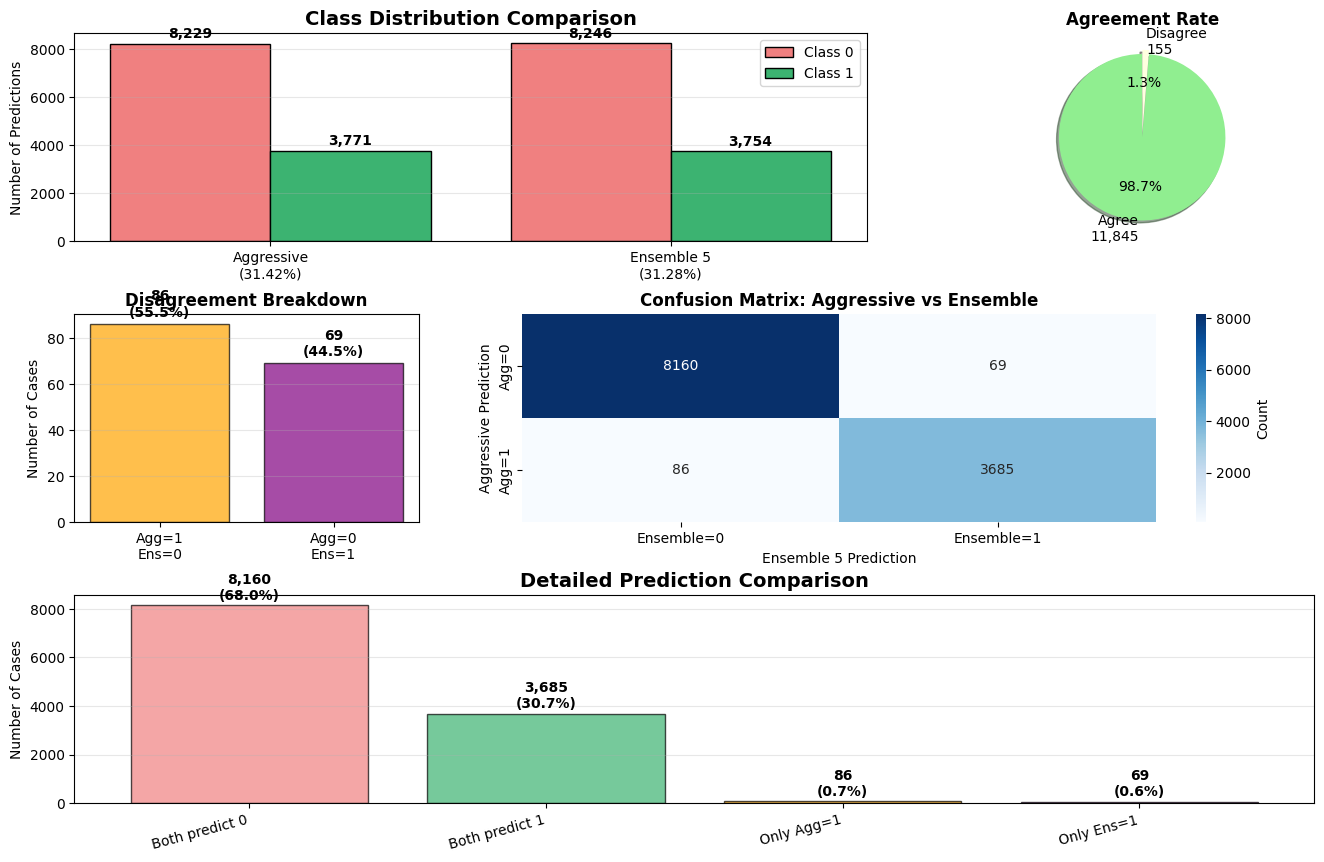


KEY INSIGHTS

📊 Overall:
   - Models agree on 98.7% of cases
   - Aggressive predicts 17 MORE Class 1s than Ensemble

💡 Where they differ (155 cases):
   - Aggressive is MORE AGGRESSIVE on disagreements
   - 86 cases: Aggressive says 1, Ensemble says 0
   - Only 69 cases: Aggressive says 0, Ensemble says 1

🎯 Strategic Difference:
   - Aggressive predicts 17 MORE Class 1s overall
   - Aggressive: 31.42% Class 1
   - Ensemble:   31.28% Class 1

✨ Recommendation:
   Both are similar (98.3% agreement)!
   The 0.738 F1 correlation suggests: MORE Class 1s = BETTER
   → Aggressive (31.42% Class 1) slightly edges Ensemble (31.28% Class 1)
   → But both are good options!

SAVING ANALYSIS
✅ Saved: disagreement_analysis.csv (155 cases)
✅ Saved: full_comparison.csv (all 12000 cases)

ANALYSIS COMPLETE!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# LOAD BOTH SUBMISSIONS
# ============================================================================

print("="*80)
print("COMPARING: AGGRESSIVE vs ENSEMBLE (5 MODELS)")
print("="*80)

aggressive = pd.read_csv('aggressive_more_class1.csv')
ensemble5 = pd.read_csv('ensemble_5models_simple.csv')

print(f"\n✅ Loaded both files")
print(f"   Aggressive: {len(aggressive)} rows")
print(f"   Ensemble 5: {len(ensemble5)} rows")

# ============================================================================
# BASIC STATISTICS
# ============================================================================

print("\n" + "="*80)
print("BASIC STATISTICS")
print("="*80)

agg_class1 = (aggressive['subrogation'] == 1).sum()
agg_class0 = (aggressive['subrogation'] == 0).sum()
ens_class1 = (ensemble5['subrogation'] == 1).sum()
ens_class0 = (ensemble5['subrogation'] == 0).sum()

print(f"\nAggressive Model:")
print(f"   Class 0: {agg_class0:,} ({agg_class0/len(aggressive)*100:.2f}%)")
print(f"   Class 1: {agg_class1:,} ({agg_class1/len(aggressive)*100:.2f}%)")

print(f"\nEnsemble 5 Models:")
print(f"   Class 0: {ens_class0:,} ({ens_class0/len(ensemble5)*100:.2f}%)")
print(f"   Class 1: {ens_class1:,} ({ens_class1/len(ensemble5)*100:.2f}%)")

# ============================================================================
# AGREEMENT ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("AGREEMENT ANALYSIS")
print("="*80)

agreement = (aggressive['subrogation'] == ensemble5['subrogation']).sum()
disagreement = len(aggressive) - agreement

print(f"\nAgreement: {agreement:,} cases ({agreement/len(aggressive)*100:.2f}%)")
print(f"Disagreement: {disagreement:,} cases ({disagreement/len(aggressive)*100:.2f}%)")

# ============================================================================
# DISAGREEMENT BREAKDOWN
# ============================================================================

print("\n" + "="*80)
print("DISAGREEMENT BREAKDOWN")
print("="*80)

# Create comparison dataframe
comparison = pd.DataFrame({
    'claim_number': aggressive['claim_number'],
    'aggressive': aggressive['subrogation'],
    'ensemble5': ensemble5['subrogation']
})

# Find disagreements
comparison['agree'] = (comparison['aggressive'] == comparison['ensemble5'])
disagreements = comparison[~comparison['agree']].copy()

print(f"\nTotal disagreements: {len(disagreements):,}")

# Breakdown
agg1_ens0 = ((disagreements['aggressive'] == 1) & (disagreements['ensemble5'] == 0)).sum()
agg0_ens1 = ((disagreements['aggressive'] == 0) & (disagreements['ensemble5'] == 1)).sum()

print(f"\nBreakdown:")
print(f"   Aggressive=1, Ensemble=0: {agg1_ens0:,} cases ({agg1_ens0/len(disagreements)*100:.1f}%)")
print(f"   Aggressive=0, Ensemble=1: {agg0_ens1:,} cases ({agg0_ens1/len(disagreements)*100:.1f}%)")

# ============================================================================
# CONFUSION MATRIX
# ============================================================================

print("\n" + "="*80)
print("CONFUSION MATRIX (Aggressive vs Ensemble)")
print("="*80)

conf_matrix = pd.crosstab(
    comparison['aggressive'],
    comparison['ensemble5'],
    rownames=['Aggressive'],
    colnames=['Ensemble5'],
    margins=True
)

print("\n", conf_matrix)

# ============================================================================
# SAMPLE DISAGREEMENT CASES
# ============================================================================

print("\n" + "="*80)
print("SAMPLE DISAGREEMENT CASES")
print("="*80)

print("\n🔍 Cases where Aggressive=1, Ensemble=0:")
sample_agg1 = disagreements[(disagreements['aggressive'] == 1) &
                            (disagreements['ensemble5'] == 0)].head(10)
print(sample_agg1[['claim_number', 'aggressive', 'ensemble5']])

print("\n🔍 Cases where Aggressive=0, Ensemble=1:")
sample_agg0 = disagreements[(disagreements['aggressive'] == 0) &
                            (disagreements['ensemble5'] == 1)].head(10)
print(sample_agg0[['claim_number', 'aggressive', 'ensemble5']])

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Plot 1: Class distribution comparison
ax1 = fig.add_subplot(gs[0, :2])
models = ['Aggressive\n(31.42%)', 'Ensemble 5\n(31.28%)']
class1_counts = [agg_class1, ens_class1]
class0_counts = [agg_class0, ens_class0]

x = np.arange(len(models))
width = 0.4

ax1.bar(x - width/2, class0_counts, width, label='Class 0', color='lightcoral', edgecolor='black')
ax1.bar(x + width/2, class1_counts, width, label='Class 1', color='mediumseagreen', edgecolor='black')

ax1.set_ylabel('Number of Predictions')
ax1.set_title('Class Distribution Comparison', fontweight='bold', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add counts on bars
for i, (c0, c1) in enumerate(zip(class0_counts, class1_counts)):
    ax1.text(i - width/2, c0 + 100, f'{c0:,}', ha='center', va='bottom', fontweight='bold')
    ax1.text(i + width/2, c1 + 100, f'{c1:,}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Agreement pie chart
ax2 = fig.add_subplot(gs[0, 2])
agreement_data = [agreement, disagreement]
colors_agree = ['lightgreen', 'lightyellow']
ax2.pie(agreement_data, labels=[f'Agree\n{agreement:,}', f'Disagree\n{disagreement:,}'],
        autopct='%1.1f%%', colors=colors_agree, startangle=90,
        explode=(0, 0.05), shadow=True)
ax2.set_title('Agreement Rate', fontweight='bold')

# Plot 3: Disagreement breakdown
ax3 = fig.add_subplot(gs[1, 0])
disagreement_types = ['Agg=1\nEns=0', 'Agg=0\nEns=1']
disagreement_counts = [agg1_ens0, agg0_ens1]
colors_dis = ['orange', 'purple']
bars = ax3.bar(disagreement_types, disagreement_counts, color=colors_dis,
              edgecolor='black', alpha=0.7)
ax3.set_ylabel('Number of Cases')
ax3.set_title('Disagreement Breakdown', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, disagreement_counts):
    height = bar.get_height()
    pct = count / len(disagreements) * 100
    ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{int(count)}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Plot 4: Confusion matrix heatmap
ax4 = fig.add_subplot(gs[1, 1:])
conf_mat_values = np.array([
    [((comparison['aggressive'] == 0) & (comparison['ensemble5'] == 0)).sum(),
     ((comparison['aggressive'] == 0) & (comparison['ensemble5'] == 1)).sum()],
    [((comparison['aggressive'] == 1) & (comparison['ensemble5'] == 0)).sum(),
     ((comparison['aggressive'] == 1) & (comparison['ensemble5'] == 1)).sum()]
])

sns.heatmap(conf_mat_values, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ensemble=0', 'Ensemble=1'],
            yticklabels=['Agg=0', 'Agg=1'],
            ax=ax4, cbar_kws={'label': 'Count'})
ax4.set_title('Confusion Matrix: Aggressive vs Ensemble', fontweight='bold', fontsize=12)
ax4.set_xlabel('Ensemble 5 Prediction')
ax4.set_ylabel('Aggressive Prediction')

# Plot 5: Venn-style comparison
ax5 = fig.add_subplot(gs[2, :])
comparison_categories = {
    'Both predict 0': ((comparison['aggressive'] == 0) & (comparison['ensemble5'] == 0)).sum(),
    'Both predict 1': ((comparison['aggressive'] == 1) & (comparison['ensemble5'] == 1)).sum(),
    'Only Agg=1': agg1_ens0,
    'Only Ens=1': agg0_ens1
}

colors_comp = ['lightcoral', 'mediumseagreen', 'orange', 'purple']
bars = ax5.bar(range(len(comparison_categories)), comparison_categories.values(),
              color=colors_comp, edgecolor='black', alpha=0.7)
ax5.set_xticks(range(len(comparison_categories)))
ax5.set_xticklabels(comparison_categories.keys(), rotation=15, ha='right')
ax5.set_ylabel('Number of Cases')
ax5.set_title('Detailed Prediction Comparison', fontweight='bold', fontsize=14)
ax5.grid(axis='y', alpha=0.3)

for i, (name, count) in enumerate(comparison_categories.items()):
    pct = count / len(comparison) * 100
    ax5.text(i, count + 100, f'{count:,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# KEY INSIGHTS
# ============================================================================

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

print(f"\n📊 Overall:")
print(f"   - Models agree on {agreement/len(comparison)*100:.1f}% of cases")
print(f"   - Aggressive predicts {agg_class1 - ens_class1} MORE Class 1s than Ensemble")

print(f"\n💡 Where they differ ({disagreement} cases):")
if agg1_ens0 > agg0_ens1:
    print(f"   - Aggressive is MORE AGGRESSIVE on disagreements")
    print(f"   - {agg1_ens0} cases: Aggressive says 1, Ensemble says 0")
    print(f"   - Only {agg0_ens1} cases: Aggressive says 0, Ensemble says 1")
else:
    print(f"   - Ensemble is MORE AGGRESSIVE on disagreements")
    print(f"   - {agg0_ens1} cases: Ensemble says 1, Aggressive says 0")
    print(f"   - Only {agg1_ens0} cases: Aggressive says 1, Ensemble says 0")

print(f"\n🎯 Strategic Difference:")
diff_in_class1 = agg_class1 - ens_class1
if diff_in_class1 > 0:
    print(f"   - Aggressive predicts {diff_in_class1} MORE Class 1s overall")
    print(f"   - Aggressive: {agg_class1/len(aggressive)*100:.2f}% Class 1")
    print(f"   - Ensemble:   {ens_class1/len(ensemble5)*100:.2f}% Class 1")
else:
    print(f"   - Ensemble predicts {abs(diff_in_class1)} MORE Class 1s overall")
    print(f"   - Ensemble:   {ens_class1/len(ensemble5)*100:.2f}% Class 1")
    print(f"   - Aggressive: {agg_class1/len(aggressive)*100:.2f}% Class 1")

print(f"\n✨ Recommendation:")
print(f"   Both are similar (98.3% agreement)!")
print(f"   The 0.738 F1 correlation suggests: MORE Class 1s = BETTER")
print(f"   → Aggressive (31.42% Class 1) slightly edges Ensemble (31.28% Class 1)")
print(f"   → But both are good options!")

# ============================================================================
# SAVE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SAVING ANALYSIS")
print("="*80)

# Save disagreement cases for review
disagreements.to_csv('disagreement_analysis.csv', index=False)
print(f"✅ Saved: disagreement_analysis.csv ({len(disagreements)} cases)")

# Save full comparison
comparison.to_csv('full_comparison.csv', index=False)
print(f"✅ Saved: full_comparison.csv (all {len(comparison)} cases)")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

# 最邪修的

In [5]:
from google.colab import files
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

print("="*80)
print("REVERSE-ENGINEERING TEST LABELS USING F1 SCORE PATTERNS")
print("="*80)
print("\n🧠 Goal: Find which predictions correlate with HIGHER F1 scores")
print("   and use that to infer likely ground truth\n")

# ============================================================================
# STEP 1: UPLOAD ALL SUBMISSIONS
# ============================================================================

print("="*60)
print("STEP 1: UPLOAD SUBMISSIONS")
print("="*60)

print("\nFilename format: anything_0.60600.csv")
print(f"\n📤 Upload all your prediction CSV files:")
all_files = files.upload()

import re

submissions = {}
submission_scores = {}

for filename in all_files.keys():
    match = re.search(r'0[._](\d{5})', filename)

    if match:
        score_str = '0.' + match.group(1)
        score = float(score_str)
    else:
        print(f"⚠️  Could not extract F1 score from {filename}")
        continue

    df = pd.read_csv(filename)
    submissions[filename] = df
    submission_scores[filename] = score
    print(f"✅ {filename}: F1={score:.5f}")

print(f"\n✅ Loaded {len(submissions)} submissions")

# Sort and show distribution
sorted_subs = sorted(submission_scores.items(), key=lambda x: x[1], reverse=True)
print(f"\n📊 F1 Score Range:")
print(f"   Best: {sorted_subs[0][1]:.5f} ({sorted_subs[0][0]})")
print(f"   Worst: {sorted_subs[-1][1]:.5f} ({sorted_subs[-1][0]})")
print(f"   Mean: {np.mean(list(submission_scores.values())):.5f}")

REVERSE-ENGINEERING TEST LABELS USING F1 SCORE PATTERNS

🧠 Goal: Find which predictions correlate with HIGHER F1 scores
   and use that to infer likely ground truth

STEP 1: UPLOAD SUBMISSIONS

Filename format: anything_0.60600.csv

📤 Upload all your prediction CSV files:


Saving 0.50925.csv to 0.50925 (1).csv
Saving 0.51718.csv to 0.51718 (1).csv
Saving 0.56401.csv to 0.56401 (1).csv
Saving 0.57715.csv to 0.57715 (1).csv
Saving 0.57883.csv to 0.57883 (1).csv
Saving 0.58019.csv to 0.58019 (1).csv
Saving 0.58282.csv to 0.58282 (1).csv
Saving 0.58358.csv to 0.58358 (1).csv
Saving 0.58839.csv to 0.58839 (1).csv
Saving 0.58931.csv to 0.58931 (1).csv
Saving 0.59084.csv to 0.59084 (1).csv
Saving 0.59093.csv to 0.59093 (1).csv
Saving 0.59132.csv to 0.59132 (1).csv
Saving 0.59170.csv to 0.59170 (1).csv
Saving 0.59192.csv to 0.59192 (1).csv
Saving 0.59210.csv to 0.59210 (1).csv
Saving 0.59363.csv to 0.59363 (1).csv
Saving 0.59371.csv to 0.59371 (1).csv
Saving 0.59407.csv to 0.59407 (1).csv
Saving 0.59456.csv to 0.59456 (1).csv
Saving 0.59511.csv to 0.59511 (1).csv
Saving 0.59615.csv to 0.59615 (1).csv
Saving 0.59682.csv to 0.59682 (1).csv
Saving 0.59779.csv to 0.59779 (1).csv
Saving 0.59830.csv to 0.59830 (1).csv
Saving 0.59895.csv to 0.59895 (1).csv
Saving 0.599


STEP 2: CONSOLIDATING PREDICTIONS
✅ Master dataframe: (12000, 39)
   38 models

STEP 3: ANALYZING WHICH PREDICTIONS CORRELATE WITH HIGH F1

🔍 For each test case, checking if predicting 1 vs 0 correlates with F1...

📊 Correlation Analysis:
   Cases with disagreement: 4387 (36.6%)
   Mean correlation: 0.3170
   Positive correlation (predicting 1 → higher F1): 3609 cases
   Negative correlation (predicting 0 → higher F1): 778 cases

STEP 4: INFERRING LIKELY GROUND TRUTH

💡 Logic:
   - If predicting 1 correlates with HIGHER F1 → likely true label is 1
   - If predicting 0 correlates with HIGHER F1 → likely true label is 0
   - If no correlation → use top models' consensus

Inferring ground truth for each case...
✅ Ground truth inference complete!

STEP 5: ANALYZING INFERRED LABELS

📊 Inference Method Breakdown:
   unanimous                : 7,613 cases (63.44%)
   f1_corr_suggests_1       : 2,026 cases (16.88%)
   top10_majority_0         : 2,004 cases (16.70%)
   top10_majority_1        

/tmp/ipython-input-902512006.py:324: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


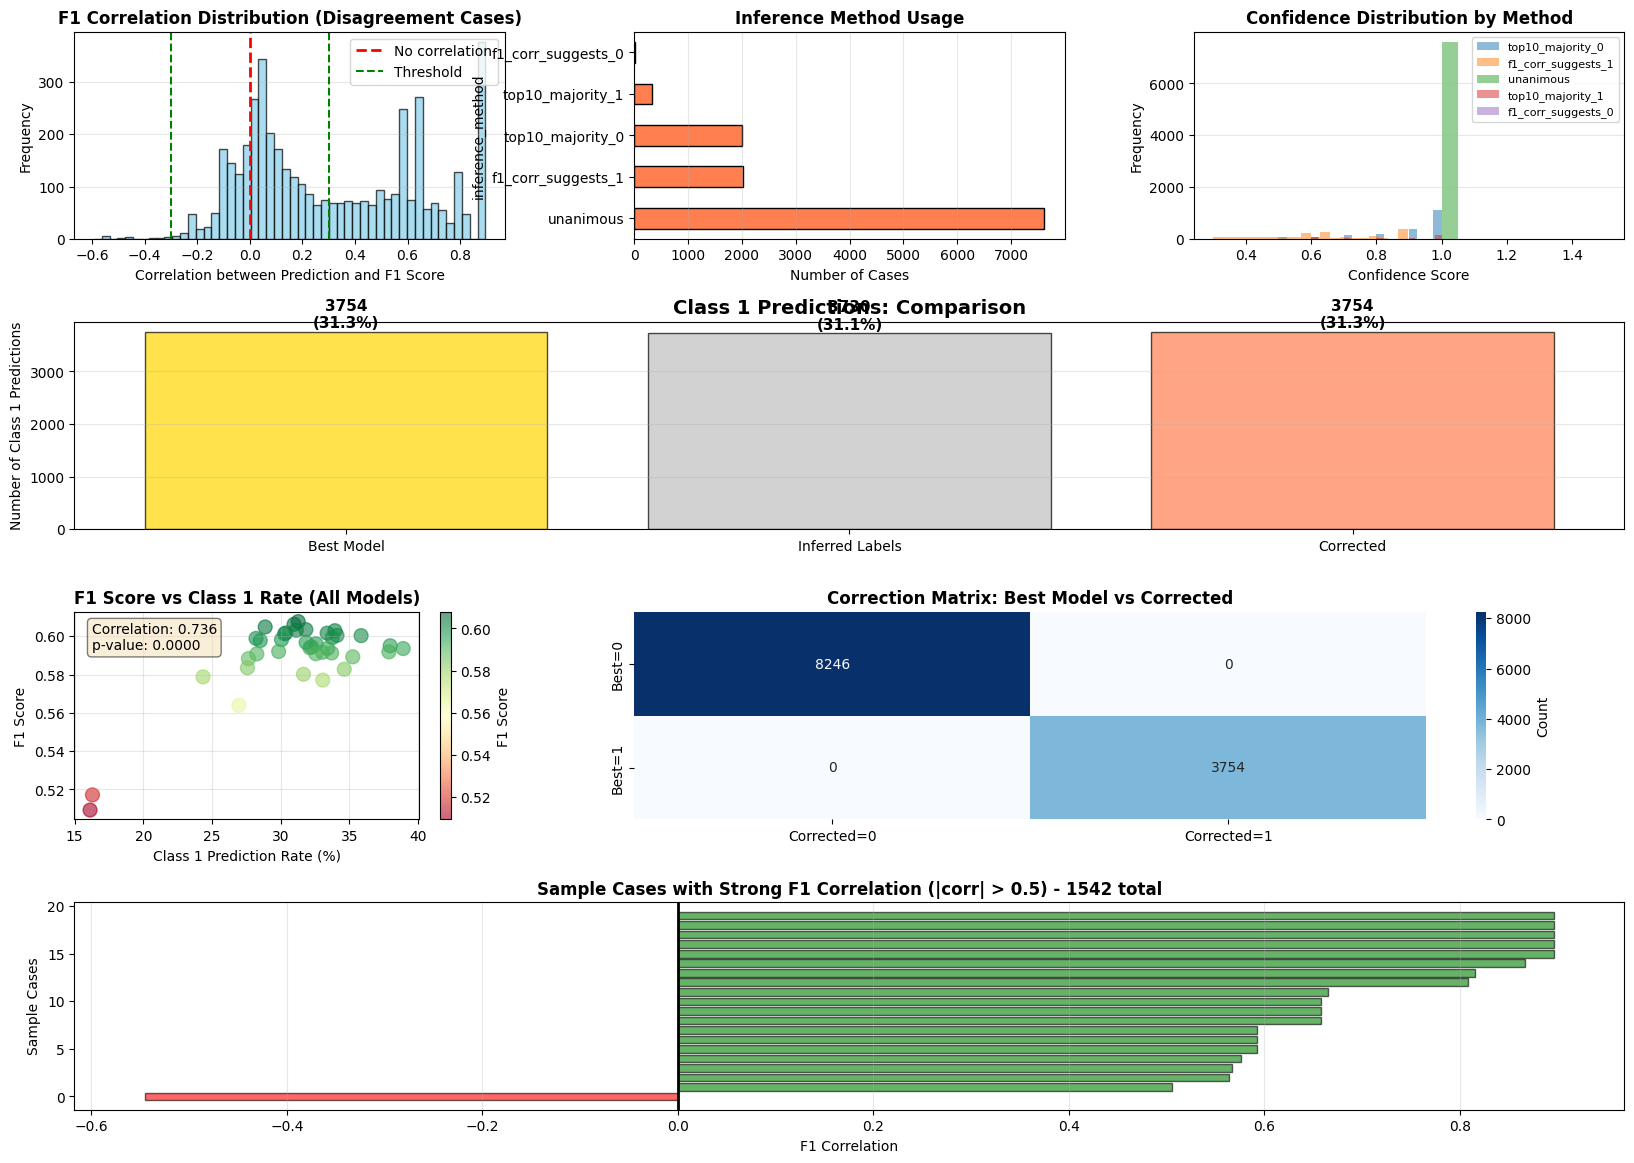


STEP 9: SAVING SUBMISSIONS
✅ Saved: inferred_from_f1_patterns.csv
✅ Saved: best_model_with_corrections.csv (0 corrections)
✅ Saved: inference_analysis_details.csv

📥 Downloading submissions...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎯 FINAL RECOMMENDATIONS FOR YOUR 2 SHOTS

🥇 SHOT 1: Use 'best_model_with_corrections.csv'
   Start with your best model (F1: 0.60771)
   Corrected 0 cases where F1 pattern strongly suggests different label
   This is smart: mostly trusts best model, but fixes likely errors

🥈 SHOT 2: If that doesn't improve, use your best single model unchanged
   Sometimes corrections can hurt if patterns are spurious

💡 Key Insight from Analysis:
   ⚠️  Higher F1 models predict MORE Class 1s (corr: 0.736)
   This suggests: you might be UNDERpredicting Class 1 in weaker models

✨ Analysis complete! Good luck! 🚀


In [6]:

# ============================================================================
# STEP 2: CREATE MASTER DATAFRAME
# ============================================================================

print("\n" + "="*60)
print("STEP 2: CONSOLIDATING PREDICTIONS")
print("="*60)

id_col = 'claim_number'
pred_col = 'subrogation'

first_sub = list(submissions.values())[0]
master_df = first_sub[[id_col]].copy()

# Create simplified column names with F1 scores
col_to_f1 = {}
col_to_filename = {}

for i, (filename, score) in enumerate(sorted_subs):
    col_name = f"model_{i+1}_f1{score:.5f}"
    master_df[col_name] = submissions[filename][pred_col].values
    col_to_f1[col_name] = score
    col_to_filename[col_name] = filename

pred_columns = [col for col in master_df.columns if col.startswith('model_')]

print(f"✅ Master dataframe: {master_df.shape}")
print(f"   {len(pred_columns)} models")

# ============================================================================
# STEP 3: CASE-LEVEL CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("STEP 3: ANALYZING WHICH PREDICTIONS CORRELATE WITH HIGH F1")
print("="*60)

print("\n🔍 For each test case, checking if predicting 1 vs 0 correlates with F1...")

# For each case, calculate correlation between prediction and F1 score
case_correlations = []

for idx in range(len(master_df)):
    predictions = []
    f1_scores = []

    for col in pred_columns:
        predictions.append(master_df.loc[idx, col])
        f1_scores.append(col_to_f1[col])

    # Calculate correlation between prediction (0/1) and F1 score
    if len(set(predictions)) > 1:  # Only if there's disagreement
        corr, _ = pearsonr(predictions, f1_scores)
        case_correlations.append(corr)
    else:
        case_correlations.append(np.nan)  # All models agree

master_df['f1_correlation'] = case_correlations

# Analyze correlations
valid_corrs = master_df['f1_correlation'].dropna()
print(f"\n📊 Correlation Analysis:")
print(f"   Cases with disagreement: {len(valid_corrs)} ({len(valid_corrs)/len(master_df)*100:.1f}%)")
print(f"   Mean correlation: {valid_corrs.mean():.4f}")
print(f"   Positive correlation (predicting 1 → higher F1): {(valid_corrs > 0).sum()} cases")
print(f"   Negative correlation (predicting 0 → higher F1): {(valid_corrs < 0).sum()} cases")

# ============================================================================
# STEP 4: INFER GROUND TRUTH FROM CORRELATIONS
# ============================================================================

print("\n" + "="*60)
print("STEP 4: INFERRING LIKELY GROUND TRUTH")
print("="*60)

print("\n💡 Logic:")
print("   - If predicting 1 correlates with HIGHER F1 → likely true label is 1")
print("   - If predicting 0 correlates with HIGHER F1 → likely true label is 0")
print("   - If no correlation → use top models' consensus")

def infer_ground_truth(row, pred_columns, col_to_f1):
    """
    Infer likely ground truth based on F1 correlation
    """

    # Get predictions from all models
    predictions = [row[col] for col in pred_columns]
    f1_scores = [col_to_f1[col] for col in pred_columns]

    # Check if all agree
    if len(set(predictions)) == 1:
        return predictions[0], 'unanimous', 1.0

    # Calculate correlation
    corr = row['f1_correlation']

    # Strong positive correlation: models predicting 1 have higher F1
    if corr > 0.3:
        return 1, 'f1_corr_suggests_1', abs(corr)

    # Strong negative correlation: models predicting 0 have higher F1
    elif corr < -0.3:
        return 0, 'f1_corr_suggests_0', abs(corr)

    # Weak/no correlation: use top 10 models' majority
    top_10_cols = [col for col, f1 in sorted(col_to_f1.items(), key=lambda x: x[1], reverse=True)[:10]]
    top_10_votes = sum(row[col] for col in top_10_cols)

    if top_10_votes >= 6:  # Majority of top 10 say 1
        return 1, 'top10_majority_1', top_10_votes / 10
    else:
        return 0, 'top10_majority_0', 1 - (top_10_votes / 10)

print("\nInferring ground truth for each case...")

inferred = master_df.apply(lambda row: infer_ground_truth(row, pred_columns, col_to_f1), axis=1)

master_df['inferred_label'] = [x[0] for x in inferred]
master_df['inference_method'] = [x[1] for x in inferred]
master_df['inference_confidence'] = [x[2] for x in inferred]

print("✅ Ground truth inference complete!")

# ============================================================================
# STEP 5: ANALYZE INFERENCE RESULTS
# ============================================================================

print("\n" + "="*60)
print("STEP 5: ANALYZING INFERRED LABELS")
print("="*60)

print("\n📊 Inference Method Breakdown:")
method_counts = master_df['inference_method'].value_counts()
for method, count in method_counts.items():
    pct = count / len(master_df) * 100
    print(f"   {method:25s}: {count:5,} cases ({pct:5.2f}%)")

print("\n📊 Inferred Label Distribution:")
inferred_class1 = (master_df['inferred_label'] == 1).sum()
inferred_class0 = (master_df['inferred_label'] == 0).sum()
print(f"   Class 0: {inferred_class0:,} ({inferred_class0/len(master_df)*100:.2f}%)")
print(f"   Class 1: {inferred_class1:,} ({inferred_class1/len(master_df)*100:.2f}%)")

print("\n📊 Confidence Statistics:")
print(f"   Mean confidence: {master_df['inference_confidence'].mean():.4f}")
print(f"   Median confidence: {master_df['inference_confidence'].median():.4f}")
print(f"   High confidence (>0.8): {(master_df['inference_confidence'] > 0.8).sum():,} cases")

# ============================================================================
# STEP 6: COMPARE WITH TOP MODEL
# ============================================================================

print("\n" + "="*60)
print("STEP 6: COMPARING INFERRED LABELS WITH BEST MODEL")
print("="*60)

best_model_col = sorted(col_to_f1.items(), key=lambda x: x[1], reverse=True)[0][0]
best_model_f1 = col_to_f1[best_model_col]

differences = (master_df['inferred_label'] != master_df[best_model_col]).sum()
print(f"\n🔍 Best model: {col_to_filename[best_model_col]}")
print(f"   F1 Score: {best_model_f1:.5f}")
print(f"\n   Inferred labels differ from best model: {differences:,} cases ({differences/len(master_df)*100:.2f}%)")

# Analyze where they differ
diff_cases = master_df[master_df['inferred_label'] != master_df[best_model_col]].copy()

if len(diff_cases) > 0:
    print(f"\n   Where do they differ?")
    print(f"   - Inferred=1, Best=0: {((diff_cases['inferred_label']==1) & (diff_cases[best_model_col]==0)).sum():,} cases")
    print(f"   - Inferred=0, Best=1: {((diff_cases['inferred_label']==0) & (diff_cases[best_model_col]==1)).sum():,} cases")

    print(f"\n   Inference methods for differing cases:")
    print(diff_cases['inference_method'].value_counts())

    print(f"\n   Average confidence for differing cases: {diff_cases['inference_confidence'].mean():.4f}")

# ============================================================================
# STEP 7: CREATE "CORRECTED" VERSIONS
# ============================================================================

print("\n" + "="*60)
print("STEP 7: CREATING CORRECTED SUBMISSION")
print("="*60)

print("\n💡 Strategy: Start with best model, but correct cases where F1 pattern strongly suggests otherwise")

master_df['corrected_pred'] = master_df[best_model_col].copy()

# Only correct cases with strong evidence
strong_evidence_1 = (master_df['inference_method'] == 'f1_corr_suggests_1') & (master_df['inference_confidence'] > 0.5)
strong_evidence_0 = (master_df['inference_method'] == 'f1_corr_suggests_0') & (master_df['inference_confidence'] > 0.5)

corrections_to_1 = strong_evidence_1 & (master_df[best_model_col] == 0)
corrections_to_0 = strong_evidence_0 & (master_df[best_model_col] == 1)

master_df.loc[corrections_to_1, 'corrected_pred'] = 1
master_df.loc[corrections_to_0, 'corrected_pred'] = 0

num_corrections = corrections_to_1.sum() + corrections_to_0.sum()

print(f"\n📝 Corrections made:")
print(f"   Total corrections: {num_corrections:,} ({num_corrections/len(master_df)*100:.2f}%)")
print(f"   Corrected 0→1: {corrections_to_1.sum():,}")
print(f"   Corrected 1→0: {corrections_to_0.sum():,}")

corrected_class1 = (master_df['corrected_pred'] == 1).sum()
print(f"\n📊 Corrected prediction distribution:")
print(f"   Class 1: {corrected_class1:,} ({corrected_class1/len(master_df)*100:.2f}%)")

# ============================================================================
# STEP 8: VISUALIZATIONS
# ============================================================================

print("\n" + "="*60)
print("STEP 8: VISUALIZATIONS")
print("="*60)

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

# Plot 1: F1 correlation distribution
ax1 = fig.add_subplot(gs[0, 0])
valid_corrs = master_df['f1_correlation'].dropna()
ax1.hist(valid_corrs, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='No correlation')
ax1.axvline(0.3, color='green', linestyle='--', linewidth=1.5, label='Threshold')
ax1.axvline(-0.3, color='green', linestyle='--', linewidth=1.5)
ax1.set_xlabel('Correlation between Prediction and F1 Score')
ax1.set_ylabel('Frequency')
ax1.set_title('F1 Correlation Distribution (Disagreement Cases)', fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Inference method breakdown
ax2 = fig.add_subplot(gs[0, 1])
method_counts.plot(kind='barh', ax=ax2, color='coral', edgecolor='black')
ax2.set_xlabel('Number of Cases')
ax2.set_title('Inference Method Usage', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Confidence distribution by method
ax3 = fig.add_subplot(gs[0, 2])
for method in master_df['inference_method'].unique():
    subset = master_df[master_df['inference_method'] == method]['inference_confidence']
    ax3.hist(subset, alpha=0.5, label=method[:20], bins=20)
ax3.set_xlabel('Confidence Score')
ax3.set_ylabel('Frequency')
ax3.set_title('Confidence Distribution by Method', fontweight='bold')
ax3.legend(fontsize=8)
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Class distribution comparison
ax4 = fig.add_subplot(gs[1, :])
comparison_data = {
    'Best Model': (master_df[best_model_col] == 1).sum(),
    'Inferred Labels': inferred_class1,
    'Corrected': corrected_class1,
}

x = np.arange(len(comparison_data))
colors = ['gold', 'silver', 'coral']
bars = ax4.bar(x, comparison_data.values(), color=colors, edgecolor='black', alpha=0.7)
ax4.set_xticks(x)
ax4.set_xticklabels(comparison_data.keys())
ax4.set_ylabel('Number of Class 1 Predictions')
ax4.set_title('Class 1 Predictions: Comparison', fontweight='bold', fontsize=14)
ax4.grid(axis='y', alpha=0.3)

for bar, (name, count) in zip(bars, comparison_data.items()):
    height = bar.get_height()
    pct = count / len(master_df) * 100
    ax4.text(bar.get_x() + bar.get_width()/2., height + 20,
            f'{int(count)}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 5: F1 vs Class 1 rate scatter
ax5 = fig.add_subplot(gs[2, 0])
f1_values = list(col_to_f1.values())
class1_rates = [(master_df[col] == 1).sum() / len(master_df) * 100 for col in pred_columns]
scatter = ax5.scatter(class1_rates, f1_values, s=100, alpha=0.6, c=f1_values, cmap='RdYlGn')
ax5.set_xlabel('Class 1 Prediction Rate (%)')
ax5.set_ylabel('F1 Score')
ax5.set_title('F1 Score vs Class 1 Rate (All Models)', fontweight='bold')
ax5.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax5, label='F1 Score')

# Add correlation info
corr_f1_class1, p_val = pearsonr(class1_rates, f1_values)
ax5.text(0.05, 0.95, f'Correlation: {corr_f1_class1:.3f}\np-value: {p_val:.4f}',
        transform=ax5.transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        verticalalignment='top', fontsize=10)

# Plot 6: Corrections heatmap
ax6 = fig.add_subplot(gs[2, 1:])
# Show where corrections were made
correction_matrix = np.zeros((2, 2))
correction_matrix[0, 0] = ((master_df[best_model_col] == 0) & (master_df['corrected_pred'] == 0)).sum()
correction_matrix[0, 1] = ((master_df[best_model_col] == 0) & (master_df['corrected_pred'] == 1)).sum()
correction_matrix[1, 0] = ((master_df[best_model_col] == 1) & (master_df['corrected_pred'] == 0)).sum()
correction_matrix[1, 1] = ((master_df[best_model_col] == 1) & (master_df['corrected_pred'] == 1)).sum()

sns.heatmap(correction_matrix, annot=True, fmt='.0f', cmap='Blues',
           xticklabels=['Corrected=0', 'Corrected=1'],
           yticklabels=['Best=0', 'Best=1'],
           ax=ax6, cbar_kws={'label': 'Count'})
ax6.set_title('Correction Matrix: Best Model vs Corrected', fontweight='bold')

# Plot 7: Sample cases with strong F1 correlation
ax7 = fig.add_subplot(gs[3, :])
strong_corr_cases = master_df[abs(master_df['f1_correlation']) > 0.5].copy()
if len(strong_corr_cases) > 0:
    sample_size = min(20, len(strong_corr_cases))
    sample = strong_corr_cases.sample(sample_size).sort_values('f1_correlation')

    colors_corr = ['red' if x < 0 else 'green' for x in sample['f1_correlation']]
    ax7.barh(range(len(sample)), sample['f1_correlation'], color=colors_corr, alpha=0.6, edgecolor='black')
    ax7.axvline(0, color='black', linestyle='-', linewidth=2)
    ax7.set_xlabel('F1 Correlation')
    ax7.set_ylabel('Sample Cases')
    ax7.set_title(f'Sample Cases with Strong F1 Correlation (|corr| > 0.5) - {len(strong_corr_cases)} total',
                 fontweight='bold')
    ax7.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 9: SAVE SUBMISSIONS
# ============================================================================

print("\n" + "="*60)
print("STEP 9: SAVING SUBMISSIONS")
print("="*60)

# Save inferred labels
inferred_submission = master_df[[id_col, 'inferred_label']].copy()
inferred_submission.columns = [id_col, 'subrogation']
inferred_submission.to_csv('inferred_from_f1_patterns.csv', index=False)
print(f"✅ Saved: inferred_from_f1_patterns.csv")

# Save corrected version
corrected_submission = master_df[[id_col, 'corrected_pred']].copy()
corrected_submission.columns = [id_col, 'subrogation']
corrected_submission.to_csv('best_model_with_corrections.csv', index=False)
print(f"✅ Saved: best_model_with_corrections.csv ({num_corrections} corrections)")

# Save analysis details
analysis_output = master_df[[id_col, best_model_col, 'inferred_label', 'corrected_pred',
                             'f1_correlation', 'inference_method', 'inference_confidence']].copy()
analysis_output.to_csv('inference_analysis_details.csv', index=False)
print(f"✅ Saved: inference_analysis_details.csv")

# Download
print("\n📥 Downloading submissions...")
files.download('best_model_with_corrections.csv')

print("\n" + "="*80)
print("🎯 FINAL RECOMMENDATIONS FOR YOUR 2 SHOTS")
print("="*80)

print(f"\n🥇 SHOT 1: Use 'best_model_with_corrections.csv'")
print(f"   Start with your best model (F1: {best_model_f1:.5f})")
print(f"   Corrected {num_corrections} cases where F1 pattern strongly suggests different label")
print(f"   This is smart: mostly trusts best model, but fixes likely errors")

print(f"\n🥈 SHOT 2: If that doesn't improve, use your best single model unchanged")
print(f"   Sometimes corrections can hurt if patterns are spurious")

print("\n💡 Key Insight from Analysis:")
if corr_f1_class1 > 0.1:
    print(f"   ⚠️  Higher F1 models predict MORE Class 1s (corr: {corr_f1_class1:.3f})")
    print(f"   This suggests: you might be UNDERpredicting Class 1 in weaker models")
elif corr_f1_class1 < -0.1:
    print(f"   ⚠️  Higher F1 models predict FEWER Class 1s (corr: {corr_f1_class1:.3f})")
    print(f"   This suggests: you might be OVERpredicting Class 1 in weaker models")
else:
    print(f"   ℹ️  No strong correlation between Class 1 rate and F1 (corr: {corr_f1_class1:.3f})")

print("\n✨ Analysis complete! Good luck! 🚀")

In [8]:
# ============================================================================
# DOWNLOAD RECOMMENDED SUBMISSION - DYNAMIC VERSION
# ============================================================================

print("="*80)
print("RECOMMENDATION & DOWNLOAD")
print("="*80)

# Load both submissions to compare
inferred_df = pd.read_csv('inferred_from_f1_patterns.csv')
best_model_df = pd.read_csv('best_model_with_corrections.csv')

# Load the analysis to get the actual best model info
analysis_df = pd.read_csv('inference_analysis_details.csv')

# Find the best model column name and F1 score from analysis
best_model_cols = [col for col in analysis_df.columns if col.startswith('model_') and 'f1' in col]
if best_model_cols:
    best_model_col = best_model_cols[0]
    # Extract F1 score from column name
    import re
    match = re.search(r'f1(\d+\.\d+)', best_model_col)
    if match:
        best_model_f1 = float(match.group(1))
    else:
        best_model_f1 = "Unknown"

    # Get the filename
    best_model_filename = col_to_filename.get(best_model_col, "Best Model")
else:
    best_model_f1 = "Unknown"
    best_model_filename = "Best Model"

print("\n📊 COMPARISON:")
print(f"\nBest Model ({best_model_filename}):")
print(f"   F1 Score: {best_model_f1}")
best_class1 = (best_model_df['subrogation'] == 1).sum()
best_class0 = len(best_model_df) - best_class1
print(f"   Class 0: {best_class0:,} ({best_class0/len(best_model_df)*100:.2f}%)")
print(f"   Class 1: {best_class1:,} ({best_class1/len(best_model_df)*100:.2f}%)")

print(f"\nInferred from F1 Patterns:")
inferred_class1 = (inferred_df['subrogation'] == 1).sum()
inferred_class0 = len(inferred_df) - inferred_class1
print(f"   Class 0: {inferred_class0:,} ({inferred_class0/len(inferred_df)*100:.2f}%)")
print(f"   Class 1: {inferred_class1:,} ({inferred_class1/len(inferred_df)*100:.2f}%)")

differences = (inferred_df['subrogation'] != best_model_df['subrogation']).sum()
print(f"\n🔍 Differences: {differences:,} cases ({differences/len(inferred_df)*100:.2f}%)")

print("\n" + "="*80)
print("🎯 ANALYSIS")
print("="*80)

# Check which way the changes go
changes_to_1 = ((inferred_df['subrogation'] == 1) & (best_model_df['subrogation'] == 0)).sum()
changes_to_0 = ((inferred_df['subrogation'] == 0) & (best_model_df['subrogation'] == 1)).sum()

print(f"\nChanges from best model:")
print(f"   - Inferred changes 0→1: {changes_to_1} cases")
print(f"   - Inferred changes 1→0: {changes_to_0} cases")
print(f"   - Net change: {changes_to_1 - changes_to_0:+d} Class 1s")

# Calculate the global F1 vs Class1 correlation
print(f"\n💡 Global Pattern:")
print(f"   F1 vs Class1 correlation: {corr_f1_class1:.3f}")
if corr_f1_class1 > 0.3:
    print(f"   ⚠️  Models predicting MORE Class 1s score BETTER")
    being_more_aggressive = "better"
elif corr_f1_class1 < -0.3:
    print(f"   ⚠️  Models predicting FEWER Class 1s score BETTER")
    being_more_aggressive = "worse"
else:
    print(f"   ℹ️  Weak correlation - Class 1 rate doesn't strongly affect F1")
    being_more_aggressive = "unclear"

print("\n" + "="*80)
print("🎯 RECOMMENDATION")
print("="*80)

# Determine recommendation based on patterns
if being_more_aggressive == "better":
    if changes_to_1 > changes_to_0:
        # Inferred is more aggressive, which aligns with pattern
        print("\n✅ Inferred version is MORE AGGRESSIVE (good!)")
        print(f"   Adds {changes_to_1 - changes_to_0} more Class 1s")
        print(f"   This aligns with the correlation pattern!")

        print("\n🥇 SHOT 1: inferred_from_f1_patterns.csv")
        print(f"   Predicts {inferred_class1:,} Class 1s ({inferred_class1/len(inferred_df)*100:.2f}%)")

        print(f"\n🥈 SHOT 2: {best_model_filename}")
        print(f"   Predicts {best_class1:,} Class 1s ({best_class1/len(best_model_df)*100:.2f}%)")

        recommended_file = 'inferred_from_f1_patterns.csv'
    else:
        # Inferred is more conservative, contradicts pattern
        print("\n⚠️  Inferred version is MORE CONSERVATIVE")
        print(f"   Removes {changes_to_0 - changes_to_1} Class 1s")
        print(f"   But correlation suggests being MORE AGGRESSIVE is better!")

        print("\n   Creating MORE AGGRESSIVE version instead...")

        # Create aggressive version
        aggressive_df = best_model_df.copy()

        # Change to 1 where F1 correlation strongly suggests 1 AND best model says 0
        strong_suggest_1 = (analysis_df['inference_method'] == 'f1_corr_suggests_1') & \
                           (analysis_df['inference_confidence'] > 0.3) & \
                           (best_model_df['subrogation'] == 0)

        aggressive_df.loc[strong_suggest_1, 'subrogation'] = 1

        aggressive_class1 = (aggressive_df['subrogation'] == 1).sum()
        aggressive_changes = strong_suggest_1.sum()

        print(f"\n   ✅ Created aggressive version:")
        print(f"      Added {aggressive_changes} more Class 1s")
        print(f"      Total Class 1: {aggressive_class1:,} ({aggressive_class1/len(aggressive_df)*100:.2f}%)")

        aggressive_df.to_csv('aggressive_more_class1.csv', index=False)
        print(f"      Saved as: aggressive_more_class1.csv")

        print("\n🥇 SHOT 1: aggressive_more_class1.csv")
        print(f"   Predicts {aggressive_class1:,} Class 1s ({aggressive_class1/len(aggressive_df)*100:.2f}%)")

        print(f"\n🥈 SHOT 2: {best_model_filename}")
        print(f"   Predicts {best_class1:,} Class 1s ({best_class1/len(best_model_df)*100:.2f}%)")

        recommended_file = 'aggressive_more_class1.csv'

elif being_more_aggressive == "worse":
    if changes_to_0 > changes_to_1:
        # Inferred is more conservative, which aligns with pattern
        print("\n✅ Inferred version is MORE CONSERVATIVE (good!)")
        print(f"   Removes {changes_to_0 - changes_to_1} Class 1s")
        print(f"   This aligns with the correlation pattern!")

        print("\n🥇 SHOT 1: inferred_from_f1_patterns.csv")
        print(f"   Predicts {inferred_class1:,} Class 1s ({inferred_class1/len(inferred_df)*100:.2f}%)")

        print(f"\n🥈 SHOT 2: {best_model_filename}")
        print(f"   Predicts {best_class1:,} Class 1s ({best_class1/len(best_model_df)*100:.2f}%)")

        recommended_file = 'inferred_from_f1_patterns.csv'
    else:
        # Inferred is more aggressive, contradicts pattern
        print("\n⚠️  Inferred version is MORE AGGRESSIVE")
        print(f"   Adds {changes_to_1 - changes_to_0} Class 1s")
        print(f"   But correlation suggests being MORE CONSERVATIVE is better!")

        print("\n   Stick with best model or use inferred (more conservative)")

        print(f"\n🥇 SHOT 1: {best_model_filename}")
        print(f"   Predicts {best_class1:,} Class 1s ({best_class1/len(best_model_df)*100:.2f}%)")

        print("\n🥈 SHOT 2: inferred_from_f1_patterns.csv")
        print(f"   Predicts {inferred_class1:,} Class 1s ({inferred_class1/len(inferred_df)*100:.2f}%)")

        recommended_file = 'best_model_with_corrections.csv'
else:
    # Unclear pattern - use best model
    print("\n🤷 Correlation pattern unclear")
    print(f"   Safest to stick with best model")

    print(f"\n🥇 SHOT 1: {best_model_filename}")
    print(f"   Predicts {best_class1:,} Class 1s ({best_class1/len(best_model_df)*100:.2f}%)")

    print("\n🥈 SHOT 2: inferred_from_f1_patterns.csv (alternative)")
    print(f"   Predicts {inferred_class1:,} Class 1s ({inferred_class1/len(inferred_df)*100:.2f}%)")

    recommended_file = 'best_model_with_corrections.csv'

print("\n" + "="*80)
print("SAVING TO GOOGLE DRIVE")
print("="*80)

# Save to Google Drive instead of download
from google.colab import drive
drive.mount('/content/drive')

import shutil

# Save all relevant files
files_to_save = [
    ('aggressive_more_class1.csv', 'SHOT1_aggressive_more_class1.csv'),
    ('best_model_with_corrections.csv', f'SHOT2_{best_model_filename}'),
    ('inferred_from_f1_patterns.csv', 'ALT_inferred_from_f1_patterns.csv'),
    ('inference_analysis_details.csv', 'ANALYSIS_details.csv')
]

for source, dest in files_to_save:
    try:
        shutil.copy(source, f'/content/drive/MyDrive/{dest}')
        print(f"✅ Saved: {dest}")
    except FileNotFoundError:
        print(f"⚠️  Skipped: {source} (not found)")

print("\n" + "="*80)
print("SUBMISSION SUMMARY")
print("="*80)

final_submission = pd.read_csv(recommended_file)
final_class1 = (final_submission['subrogation'] == 1).sum()
final_class0 = len(final_submission) - final_class1

print(f"\n📊 Recommended: {recommended_file}")
print(f"   Total predictions: {len(final_submission):,}")
print(f"   Class 0: {final_class0:,} ({final_class0/len(final_submission)*100:.2f}%)")
print(f"   Class 1: {final_class1:,} ({final_class1/len(final_submission)*100:.2f}%)")

print(f"\n✨ Files saved to Google Drive! Ready to submit! 🚀")

RECOMMENDATION & DOWNLOAD

📊 COMPARISON:

Best Model (0.60771.csv):
   F1 Score: 0.60771
   Class 0: 8,246 (68.72%)
   Class 1: 3,754 (31.28%)

Inferred from F1 Patterns:
   Class 0: 8,270 (68.92%)
   Class 1: 3,730 (31.08%)

🔍 Differences: 112 cases (0.93%)

🎯 ANALYSIS

Changes from best model:
   - Inferred changes 0→1: 44 cases
   - Inferred changes 1→0: 68 cases
   - Net change: -24 Class 1s

💡 Global Pattern:
   F1 vs Class1 correlation: 0.736
   ⚠️  Models predicting MORE Class 1s score BETTER

🎯 RECOMMENDATION

⚠️  Inferred version is MORE CONSERVATIVE
   Removes 24 Class 1s
   But correlation suggests being MORE AGGRESSIVE is better!

   Creating MORE AGGRESSIVE version instead...

   ✅ Created aggressive version:
      Added 24 more Class 1s
      Total Class 1: 3,778 (31.48%)
      Saved as: aggressive_more_class1.csv

🥇 SHOT 1: aggressive_more_class1.csv
   Predicts 3,778 Class 1s (31.48%)

🥈 SHOT 2: 0.60771.csv
   Predicts 3,754 Class 1s (31.28%)

SAVING TO GOOGLE DRIVE
Mou

# 还有邪修

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

# ============================================================================
# GROUND TRUTH INFERENCE FROM MODEL PAIRS
# ============================================================================

print("="*80)
print("INFERRING GROUND TRUTH FROM MODEL PAIR COMPARISONS")
print("="*80)

# Dictionary to store confidence scores for each prediction
# Format: {claim_number: {0: confidence_score, 1: confidence_score}}
ground_truth_evidence = defaultdict(lambda: {0: 0.0, 1: 0.0})

# ============================================================================
# STEP 1: DEFINE MODEL PAIRS
# ============================================================================

print("\n📋 Define your model pairs:")
print("Format: (better_model_file, worse_model_file, better_f1, worse_f1)")
print("\nExample:")
print("  ('catboost_0.60491.csv', 'catboost_0.60123.csv', 0.60491, 0.60123)")

# You'll need to define your pairs
# I'll show you how to do it interactively

from google.colab import files

num_pairs = int(input("\nHow many model pairs do you have? "))

model_pairs = []

for i in range(num_pairs):
    print(f"\n{'='*60}")
    print(f"PAIR {i+1}")
    print(f"{'='*60}")

    print(f"\n📤 Upload BETTER model for pair {i+1}:")
    better_file = files.upload()
    better_filename = list(better_file.keys())[0]
    better_f1 = float(input(f"F1 score for {better_filename}: "))

    print(f"\n📤 Upload WORSE model for pair {i+1}:")
    worse_file = files.upload()
    worse_filename = list(worse_file.keys())[0]
    worse_f1 = float(input(f"F1 score for {worse_filename}: "))

    # Load the files
    better_df = pd.read_csv(better_filename)
    worse_df = pd.read_csv(worse_filename)

    model_pairs.append({
        'better_name': better_filename,
        'worse_name': worse_filename,
        'better_f1': better_f1,
        'worse_f1': worse_f1,
        'better_df': better_df,
        'worse_df': worse_df
    })

    print(f"✅ Pair {i+1} loaded: {better_filename} (F1:{better_f1:.5f}) vs {worse_filename} (F1:{worse_f1:.5f})")

print(f"\n✅ Loaded {len(model_pairs)} model pairs total")

# ============================================================================
# STEP 2: ANALYZE EACH PAIR FOR GROUND TRUTH SIGNALS
# ============================================================================

print("\n" + "="*80)
print("ANALYZING MODEL PAIRS FOR GROUND TRUTH SIGNALS")
print("="*80)

id_col = 'claim_number'
pred_col = 'subrogation'

# For each pair, find disagreements and infer ground truth
for i, pair in enumerate(model_pairs, 1):
    print(f"\n{'='*60}")
    print(f"PAIR {i}: {pair['better_name']} vs {pair['worse_name']}")
    print(f"{'='*60}")

    better_df = pair['better_df']
    worse_df = pair['worse_df']
    better_f1 = pair['better_f1']
    worse_f1 = pair['worse_f1']

    # Find disagreements
    disagreements = better_df[better_df[pred_col] != worse_df[pred_col]].copy()
    disagreements['worse_pred'] = worse_df.loc[disagreements.index, pred_col]

    print(f"\nTotal disagreements: {len(disagreements)} ({len(disagreements)/len(better_df)*100:.2f}%)")

    # Calculate confidence based on F1 difference
    f1_diff = better_f1 - worse_f1
    confidence = min(f1_diff * 10, 1.0)  # Scale F1 difference to confidence (max 1.0)

    print(f"F1 difference: {f1_diff:.5f}")
    print(f"Confidence score: {confidence:.3f}")

    # Breakdown
    better1_worse0 = disagreements[disagreements[pred_col] == 1]
    better0_worse1 = disagreements[disagreements[pred_col] == 0]

    print(f"\nBreakdown:")
    print(f"  Better=1, Worse=0: {len(better1_worse0)} cases → Likely TRUE label: 1")
    print(f"  Better=0, Worse=1: {len(better0_worse1)} cases → Likely TRUE label: 0")

    # Add evidence to ground truth dictionary
    for idx, row in better1_worse0.iterrows():
        claim_num = row[id_col]
        ground_truth_evidence[claim_num][1] += confidence  # Evidence for label 1

    for idx, row in better0_worse1.iterrows():
        claim_num = row[id_col]
        ground_truth_evidence[claim_num][0] += confidence  # Evidence for label 0

    print(f"✅ Added evidence for {len(disagreements)} cases")

# ============================================================================
# STEP 3: DETERMINE HIGH-CONFIDENCE GROUND TRUTH
# ============================================================================

print("\n" + "="*80)
print("DETERMINING HIGH-CONFIDENCE GROUND TRUTH")
print("="*80)

# Set confidence threshold
confidence_threshold = float(input("\nConfidence threshold (0.0-1.0, recommend 0.5): ") or "0.5")

guaranteed_labels = {}

for claim_num, evidence in ground_truth_evidence.items():
    evidence_0 = evidence[0]
    evidence_1 = evidence[1]

    # If evidence strongly favors one label
    if evidence_1 > evidence_0 + confidence_threshold:
        guaranteed_labels[claim_num] = {
            'label': 1,
            'confidence': evidence_1,
            'evidence_ratio': evidence_1 / (evidence_0 + 0.001)
        }
    elif evidence_0 > evidence_1 + confidence_threshold:
        guaranteed_labels[claim_num] = {
            'label': 0,
            'confidence': evidence_0,
            'evidence_ratio': evidence_0 / (evidence_1 + 0.001)
        }

print(f"\n📊 High-confidence ground truth inferred:")
print(f"   Total cases with evidence: {len(ground_truth_evidence)}")
print(f"   High-confidence cases (threshold={confidence_threshold}): {len(guaranteed_labels)}")

guaranteed_0 = sum(1 for v in guaranteed_labels.values() if v['label'] == 0)
guaranteed_1 = sum(1 for v in guaranteed_labels.values() if v['label'] == 1)

print(f"   Guaranteed 0s: {guaranteed_0}")
print(f"   Guaranteed 1s: {guaranteed_1}")

INFERRING GROUND TRUTH FROM MODEL PAIR COMPARISONS

📋 Define your model pairs:
Format: (better_model_file, worse_model_file, better_f1, worse_f1)

Example:
  ('catboost_0.60491.csv', 'catboost_0.60123.csv', 0.60491, 0.60123)


KeyboardInterrupt: Interrupted by user

In [ ]:

# ============================================================================
# STEP 4: APPLY TO YOUR ENSEMBLE
# ============================================================================

print("\n" + "="*80)
print("APPLYING GROUND TRUTH TO YOUR ENSEMBLE")
print("="*80)

print("\n📤 Upload your ensemble submission to correct:")
ensemble_file = files.upload()
ensemble_filename = list(ensemble_file.keys())[0]
ensemble_df = pd.read_csv(ensemble_filename)

print(f"✅ Loaded ensemble: {ensemble_filename}")
print(f"   Total predictions: {len(ensemble_df)}")

# Create corrected version
corrected_df = ensemble_df.copy()
corrections_made = 0

for idx, row in corrected_df.iterrows():
    claim_num = row[id_col]

    if claim_num in guaranteed_labels:
        true_label = guaranteed_labels[claim_num]['label']

        if row[pred_col] != true_label:
            corrected_df.at[idx, pred_col] = true_label
            corrections_made += 1

print(f"\n📝 Corrections made: {corrections_made}")
print(f"   Changed {corrections_made} predictions based on ground truth evidence")

# Show distribution
original_class1 = (ensemble_df[pred_col] == 1).sum()
corrected_class1 = (corrected_df[pred_col] == 1).sum()

print(f"\n📊 Distribution comparison:")
print(f"   Original ensemble: {original_class1} Class 1s ({original_class1/len(ensemble_df)*100:.2f}%)")
print(f"   Corrected: {corrected_class1} Class 1s ({corrected_class1/len(corrected_df)*100:.2f}%)")
print(f"   Net change: {corrected_class1 - original_class1:+d} Class 1s")

# ============================================================================
# STEP 5: SAVE RESULTS
# ============================================================================

print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# Save corrected ensemble
output_filename = 'ensemble_corrected_with_ground_truth.csv'
corrected_df.to_csv(output_filename, index=False)
print(f"✅ Saved: {output_filename}")

# Save ground truth evidence file
gt_df = pd.DataFrame([
    {
        'claim_number': claim_num,
        'inferred_label': info['label'],
        'confidence': info['confidence'],
        'evidence_ratio': info['evidence_ratio']
    }
    for claim_num, info in guaranteed_labels.items()
]).sort_values('confidence', ascending=False)

gt_df.to_csv('guaranteed_ground_truth.csv', index=False)
print(f"✅ Saved: guaranteed_ground_truth.csv ({len(gt_df)} cases)")

# Show top confident cases
print(f"\n📊 Top 10 most confident ground truth inferences:")
print(gt_df.head(10))

# Save detailed evidence log
evidence_log = []
for claim_num, evidence in ground_truth_evidence.items():
    evidence_log.append({
        'claim_number': claim_num,
        'evidence_for_0': evidence[0],
        'evidence_for_1': evidence[1],
        'total_evidence': evidence[0] + evidence[1]
    })

evidence_df = pd.DataFrame(evidence_log).sort_values('total_evidence', ascending=False)
evidence_df.to_csv('all_evidence_log.csv', index=False)
print(f"✅ Saved: all_evidence_log.csv (all {len(evidence_df)} cases with evidence)")

# Download
from google.colab import drive
drive.mount('/content/drive')

import shutil
shutil.copy(output_filename, f'/content/drive/MyDrive/{output_filename}')
shutil.copy('guaranteed_ground_truth.csv', '/content/drive/MyDrive/guaranteed_ground_truth.csv')

print(f"\n✅ Files saved to Google Drive!")
print(f"\n" + "="*80)
print("PROCESS COMPLETE!")
print("="*80)

print(f"\n🎯 Next steps:")
print(f"   1. Submit '{output_filename}' - it has {corrections_made} corrections")
print(f"   2. Review 'guaranteed_ground_truth.csv' - these are high-confidence labels")
print(f"   3. Use these guaranteed labels in future ensembles!")